In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, DateType

# Configuração do Spark
spark = (
    SparkSession.builder
    .appName("Azure ML - Spark Session") 
    .getOrCreate()
)
spark

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/anaconda/envs/azureml_py38/lib/python3.10/site-packages/pyspark/jars/log4j-slf4j-impl-2.17.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/anaconda/envs/azureml_py38/lib/python3.10/site-packages/pyspark/jars/log4j-slf4j-impl-2.17.1.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]


25/06/01 23:33:46 WARN Utils: Your hostname, fernandabomtorin1 resolves to a loopback address: 127.0.0.1; using 10.0.0.4 instead (on interface eth0)
25/06/01 23:33:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/06/01 23:33:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark.sparkContext.setLogLevel("ERROR")
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# Extração dos dados e análise exploratória
- Loading dos arquivos parquet, referente as bases de dados do problema
- Base de transações, membros e logs
- Entendimento dos dados disponiveis

In [3]:
# Definição do diretório base dos dados
base_path = os.path.join(os.getcwd(), "dados")

# Loading das bases de dados
df_transactions = spark.read.parquet("/home/azureuser/cloudfiles/code/dados/transactions.parquet")
df_members = spark.read.parquet("/home/azureuser/cloudfiles/code/dados/members.parquet")
df_logs = spark.read.parquet("/home/azureuser/cloudfiles/code/dados/user_logs.parquet")

### Base de transações

In [4]:
# Transformação das colunas de data
df_transactions = df_transactions.select(
    F.col('msno'),
    F.col('payment_method_id').cast(DoubleType()),
    F.col('payment_plan_days').cast(DoubleType()),
    F.col('plan_list_price').cast(DoubleType()),
    F.col('actual_amount_paid').cast(DoubleType()),
    F.col('is_auto_renew').cast(IntegerType()),
    F.col('transaction_date'),
    F.col('membership_expire_date'),
    F.col('is_cancel').cast(IntegerType()),
    F.col('safra')
).withColumn(
    'transaction_date',
    F.to_date(F.concat(
                F.col('transaction_date').substr(1, 4),
                F.lit('-'),
                F.col('transaction_date').substr(5, 2),
                F.lit('-'),
                F.col('transaction_date').substr(7, 2)), 'yyyy-MM-dd')
).withColumn(
    'membership_expire_date',
    F.to_date(F.concat(
                F.col('membership_expire_date').substr(1, 4),
                F.lit('-'),
                F.col('membership_expire_date').substr(5, 2),
                F.lit('-'),
                F.col('membership_expire_date').substr(7, 2)), 'yyyy-MM-dd')
).withColumn(
    'safra',
    F.to_date(
        F.concat(
            F.col('safra').substr(1, 4),
            F.lit('-'),
            F.col('safra').substr(5, 2),
            F.lit('-'),
            F.lit('01')), 'yyyy-MM-dd')
)

In [7]:
df_transactions.summary().show()

+-------+--------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|                msno| payment_method_id| payment_plan_days|   plan_list_price|actual_amount_paid|     is_auto_renew|          is_cancel|
+-------+--------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|  count|            20712225|          20712225|          20712225|          20712225|          20712225|          20712225|           20712225|
|   mean|                null|38.926502005458126|31.428997850303382|140.24088353617248|142.83468555406287|0.8543830998359664|0.03287691206521752|
| stddev|                null|3.5062855923423513|30.559829808399385|132.27679209056055|133.60944276809502|0.3527217381412334| 0.1783143916048489|
|    min|+++FOrTS7ab3tIgIh...|               1.0|               0.0|               0.0|               0.0|                 0

In [ ]:
print('Total de clientes: ')
print(df_transactions.select(F.countDistinct('msno')).collect()[0][0])
print('Total de transações: ')
print(df_transactions.count())

Total de clientes: 
2363626
Total de transações: 
20712225


In [ ]:
cancelamento = df_transactions.groupBy('safra').agg(
    F.mean('is_cancel').alias('percentual_cancelamento')
)
print('Média de cancelamentos mensalmente: ', cancelamento.agg(F.mean('percentual_cancelamento')).collect()[0][0])

Média de cancelamentos mensalmente:  0.03374890214137594


Observações sobre os dados de transacções:
- Nenhum valor missing
- Transações de 01-2015 à 12-2027
- 3,2% das transações foram cancelamento
- Em 85% das transações, o cliente esta com renovação automatica acionada

### Base de membros

In [5]:
df_members = df_members.select(
    F.col('msno'),
    F.col('city').cast(IntegerType()),
    F.col('bd').cast(IntegerType()),
    F.col('gender'),
    F.col('registered_via').cast(IntegerType()),
    F.col('registration_init_time'),
    F.col('is_ativo').cast(IntegerType()),
    F.col('safra')
).withColumn(
    'safra',
    F.to_date(
        F.concat(
            F.col('safra').substr(1, 4),
            F.lit('-'),
            F.col('safra').substr(5, 2),
            F.lit('-'),
            F.lit('01')), 'yyyy-MM-dd')
).withColumn(
    'registration_init_time',
    F.to_date(
        F.concat(
            F.col('registration_init_time').substr(1, 4),
            F.lit('-'),
            F.col('registration_init_time').substr(5, 2),
            F.lit('-'),
            F.col('registration_init_time').substr(7, 2)), 'yyyy-MM-dd')
)

In [8]:
df_members.summary().show()

+-------+--------------------+-----------------+------------------+--------+------------------+-------------------+
|summary|                msno|             city|                bd|  gender|    registered_via|           is_ativo|
+-------+--------------------+-----------------+------------------+--------+------------------+-------------------+
|  count|            63867246|         63867246|          63867246|25657069|          63867246|           63867246|
|   mean|                NULL|4.369941346774214|11.430160210759675|    NULL| 5.455677343594869|0.17603491154135564|
| stddev|                NULL|5.807596122789123|19.041318387984273|    NULL|2.4953863289564757| 0.3808498703308826|
|    min|+++4vcS9aMH7KWdfh...|                1|             -7168|  female|                -1|                  0|
|    25%|                NULL|                1|                 0|    NULL|                 3|                  0|
|    50%|                NULL|                1|                 0|    N

Gender
* 40% de missing para gender. Por se tratar de uma quantidade muito grande, crio uma nova categoria para os casos em que nao foi informado o gênero.

In [6]:
# Tratamento de missing para gender
df_members = df_members.na.fill({'gender': 'nao_informado'})

In [ ]:
df_members.groupBy('safra').count().show()

+----------+-------+
|     safra|  count|
+----------+-------+
|2016-03-01|4697972|
|2016-01-01|4294184|
|2016-08-01|5615921|
|2016-09-01|5778986|
|2016-05-01|5060705|
|2016-04-01|4876301|
|2016-11-01|6114345|
|2016-07-01|5439337|
|2016-12-01|6287789|
|2016-02-01|4502354|
|2016-10-01|5949288|
|2016-06-01|5250064|
+----------+-------+



In [21]:
from pyspark.sql import Window

# Calcular min, max, mean por quantil
df_members.withColumn(
    "bd_quantile", F.ntile(20).over(Window.orderBy("bd"))
).groupBy("bd_quantile").agg(
    F.min("bd").alias("min_bd"),
    F.max("bd").alias("max_bd"),
    F.mean("bd").alias("mean_bd")
).show()

# Calcular a mediana geral de bd
median_bd = df_members.approxQuantile("bd", [0.5], 0.01)[0]
print("Mediana geral de bd:", median_bd)

25/06/01 22:12:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/01 22:12:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


25/06/01 22:12:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/01 22:12:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


25/06/01 22:13:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:13:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:13:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:13:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:13:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:13:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:13:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:13:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:13:29 WARN RowBasedKeyValueBatch: Calling spill() on

+-----------+------+------+--------------------+
|bd_quantile|min_bd|max_bd|             mean_bd|
+-----------+------+------+--------------------+
|          1| -7168|     0|-0.33433906511724476|
|          2|     0|     0|                 0.0|
|          3|     0|     0|                 0.0|
|          4|     0|     0|                 0.0|
|          5|     0|     0|                 0.0|
|          6|     0|     0|                 0.0|
|          7|     0|     0|                 0.0|
|          8|     0|     0|                 0.0|
|          9|     0|     0|                 0.0|
|         10|     0|     0|                 0.0|
|         11|     0|     0|                 0.0|
|         12|     0|     0|                 0.0|
|         13|     0|    18|  10.541769144869889|
|         14|    18|    21|  19.668699320653282|
|         15|    21|    24|  22.392777267343945|
|         16|    24|    27|   25.35950449714126|
|         17|    27|    30|  28.463474231859713|
|         18|    30|

Mediana geral de bd: 0.0


In [7]:
# Utilização dos valores do percentil 99 e 1 para substituir os outliers
percentile_99_value = 51
percentile_01_value = 0

# Substituição dos valores outliers de bd
df_members = df_members.withColumn(
    'bd',
    F.when(F.col('bd') < percentile_01_value, percentile_01_value)
     .when(F.col('bd') > percentile_99_value, percentile_99_value)
     .otherwise(F.col('bd'))
)

In [9]:
print('Total de clientes: ', df_members.select(F.countDistinct('msno')).collect()[0][0])

[470.774s][warning][gc,alloc] Executor task launch worker for task 9.0 in stage 6.0 (TID 20): Retried waiting for GCLocker too often allocating 4194306 words


Total de clientes:  6287789


### Observações sobre a base de membros:
- 63MM de clientes
- Apenas 17% dos membros estao ativos

### Base logs

In [8]:
df_logs = df_logs.select(
    F.col('msno'),
    F.col('num_25').cast(DoubleType()),
    F.col('num_50').cast(DoubleType()),
    F.col('num_75').cast(DoubleType()),
    F.col('num_985').cast(DoubleType()),
    F.col('num_100').cast(DoubleType()),
    F.col('num_unq').cast(DoubleType()),
    F.col('total_secs').cast(DoubleType()),
    F.col('safra')
).withColumn(
    'safra',
    F.to_date(
        F.concat(
            F.col('safra').substr(1, 4),
            F.lit('-'),
            F.col('safra').substr(5, 2),
            F.lit('-'),
            F.lit('01')), 'yyyy-MM-dd')
)

In [ ]:
df_logs.summary().show()

+-------+--------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+--------------------+
|summary|                msno|            safra|           num_25|           num_50|            num_75|           num_985|          num_100|           num_unq|          total_secs|
+-------+--------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+--------------------+
|  count|            26758971|         26758971|         26758971|         26758971|          26758971|          26758971|         26758971|          26758971|            26758971|
|   mean|                NULL|201572.0403868669|95.42601163549973|24.03566975725636|14.903521327483034|16.538671797207748|450.1598216538297|440.91930526775485|-2.11717488634742...|
| stddev|                NULL|61.87618074610147|175.2882595645691|39.12554591867812|  22.626721

# O Case
Dados históricos de dois anos de clientes de uma empresa que oferece streaming de musica baseado em assinatura.
Quando os usuários se inscrevem no serviço, eles podem optar por renovar o serviço manualmente ou renovar automaticamente, podendo cancelar ativamente sua associação à qualquer momento.
## Modelo de Churn
Criação de um modelo classificador para prever clientes que serão churn 3 meses no futuro (ou seja, clientes que possuem assinatura ativa no periodo analisado e 3 mses depois desse período ele não esta mais ativo, ou porque cancelou ou não renovou a assinatura) e identifique os clientes que serão direcionados para a ação de forma proativa.

# Definição de público
- Clientes que possuem assinatura ativa
- Até 2016-09-01 para que possuam apenas clientes que possamos saber o comportamento 3 meses para a frente
- Na base de membros, temos a informacao dos membros ativos, e portanto escolho essa base para selecionar o público

In [9]:
spine = df_members.filter(
    (F.col('is_ativo') == 1) &
    (F.col('safra') < F.lit('2016-09-01'))
).drop('is_ativo').dropDuplicates()

In [ ]:
spine.count()

7153111

In [ ]:
spine.groupBy('msno').count().orderBy(F.desc('count')).show(5, truncate=False)

+--------------------------------------------+-----+
|msno                                        |count|
+--------------------------------------------+-----+
|+f7M2fwOgbZKfdDo7U5yF2Tn9SCxtV4TVzSydzrQI40=|8    |
|+Pn5eh2MY/PSbCwd1OW+xxZkjcgXETMtzfMf/fcvywI=|8    |
|+QrgUC+7auY8Pf0w2wi6p3nbyA9QSVySmdhAVu/wYZ8=|8    |
|+YOJTYCPOTYfnWWrwjYK9bEZjWVG++pVbCeTq0eGMhA=|8    |
|+QXJIHj6VYFkRpplljnYC+btUq/8MtESX5ng9nIff0U=|8    |
+--------------------------------------------+-----+
only showing top 5 rows



In [ ]:
spine.show(5, truncate=False)

+--------------------------------------------+----+---+-------------+--------------+----------------------+----------+
|msno                                        |city|bd |gender       |registered_via|registration_init_time|safra     |
+--------------------------------------------+----+---+-------------+--------------+----------------------+----------+
|++Bks8kE9oclzxZM3hcWs+qzsxuoXFeIE1+7pxKBCQg=|1   |0  |nao_informado|7             |2016-07-30            |2016-07-01|
|++OvJH5FmfZ5CRrYfmbQEk7tJwCZhsJnkWbxClRaUpw=|1   |0  |nao_informado|7             |2013-11-14            |2016-02-01|
|++aVm+4v87MXzbhiEXoS7OszzRxcfny8aKalISGUR9I=|15  |32 |male         |9             |2011-11-03            |2016-05-01|
|++kosgi4V03jOxcBKjM/9tPignUOxcc7jBVnZLJ+lX0=|1   |0  |nao_informado|7             |2015-07-10            |2016-07-01|
|+/EF6xPAo8HLjhC7K8VBWUkXnCYi7KYIaNf071llMV0=|5   |35 |female       |9             |2012-05-16            |2016-02-01|
+--------------------------------------------+--

# Definição da target
- Churn ou não churns, 3 meses no futuro
- Todas as variaveis sobre o cliente, estão em uma visao 3 meses antes da target
- A partir da spine, com os clientes ativos em cada safra, é feito um cruzamento buscando o cliente na safra 3 meses para o futuro
- Cria-se a variável target, 1 se o cliente estiver ativo, 0 se nao estiver ativo (churn)

In [10]:
df_members_aliased = df_members.select('msno', 'safra', 'is_ativo').withColumnRenamed('safra', 'safra_target').withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra_target')))
master = spine.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.add_months(F.col('safra'), 3)))
master = master.join(df_members_aliased.select('chave', 'is_ativo'),on='chave', how='left').drop('chave').withColumnRenamed('is_ativo', 'target')

In [ ]:
master.show(5, truncate=False)

+--------------------------------------------+----+---+-------------+--------------+----------------------+----------+------+
|msno                                        |city|bd |gender       |registered_via|registration_init_time|safra     |target|
+--------------------------------------------+----+---+-------------+--------------+----------------------+----------+------+
|+TX/zz/YToedCiHQ8OaMmRDwaGF4LU1aaNOXeo408VM=|1   |0  |nao_informado|7             |2012-05-24            |2016-06-01|1     |
|/8HWkgjEG95U3+82KEXrWRcrmkUl62cEUeg8d37j7dQ=|22  |32 |male         |3             |2016-01-14            |2016-05-01|0     |
|+a5M+g3yn6JJoUL0JLg6075GbJZBsBJ4z3FkQ2HJgBU=|1   |0  |nao_informado|7             |2016-04-09            |2016-08-01|1     |
|+mM0jyxAgO+WXyjjj1T0lIs4vYbG0zScKm/ifZ6sQYc=|1   |0  |nao_informado|7             |2014-12-20            |2016-08-01|1     |
|+2BZVWQhXddu49omjb2OOjOwVv0MTtj5l9Io4n+IAD4=|4   |54 |male         |9             |2016-01-15            |2016-03-01|

In [16]:
master.groupBy('target').count().show()

+------+-------+
|target|  count|
+------+-------+
|     1|6134030|
|     0|1019081|
+------+-------+



In [11]:
# Obtendo uma amostra, mantendo a proporção da target
fractions = {0: 0.1, 1: 0.1}

df_sample = master.sampleBy("target", fractions, seed=42)

In [36]:
# Verifique a nova distribuição
df_sample.groupBy("target").count().show()

25/06/01 22:35:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


[Stage 105:====================================================================================================================================================================================================================================================================================>                                                                                                                                                                                                      (39 + 4) / 67][Stage 110:>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            (0 + 0) / 1]

25/06/01 22:35:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/06/01 22:35:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


25/06/01 22:35:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+------+------+
|target| count|
+------+------+
|     1|615124|
|     0|101924|
+------+------+



#### *Considerações sobre público e a target*

1.   *Target desbalanceada* -> Há uma quantidade bem maior de clientes que continuaram ativos (1), que os clientes churn. Dessa forma, na hora de criar o modelo, é interessante utilizar pesos para balancear a target.
2.   *Mesmo cliente pode aparecer mais de uma vez na base* -> estamos capturando o comportamente desse cliente no mes, é necessário trazer as features sobre a transação e logs, mostrando o comportamento diferente em cada mes, e como isso impacta na target (se ele será churn ou não)
3.   *Horizonte do público em 2016* -> a target deve ser o cliente ativo ou nao, informação que é possivel de encontrar apenas na base de members, e portanto, temos apenas informações de 2016


# Feature Engineering
- Criação de novas features

#### **Transações:**

*variaveis uteis existentes:*
- is_auto_renew -> seria um indicativo de que o cliente talvez nao renove o plano?
- payment_plan_days -> indicando quanto tempo o cliente tem para renovar o plano
- actual_amount_paid -> mostrando o quanto o cliente esta pagando, se for muito pode trazer indicios de cancelamento
- membership_expire_date -> transformar em quanto tempo para finalização do plano
- is_canceled -> indicando se o plano foi cancelado ou nao -> pode indicar que o cliente cancelou e no mes seguinte a assinatura nao estara mais ativa



In [12]:
df_transactions=df_transactions.filter(F.year(F.col('safra'))=='2016')

In [ ]:
df_transactions.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra'))).groupBy('chave').count().orderBy(F.desc('count')).show(5)

+--------------------+-----+
|               chave|count|
+--------------------+-----+
|++5BmBHS2ebe4Whfg...|    1|
|++3UnufK0Ka+brv8d...|    1|
|++4yteQFM9k0Gjq5f...|    1|
|++8XaEDast796K/DQ...|    1|
|+++snpr7pmobhLKUg...|    1|
+--------------------+-----+
only showing top 5 rows



In [13]:
df_sample = df_sample.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra')))
df_sample = df_sample.join(df_transactions.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra'))).select('chave', 'is_auto_renew', 'payment_plan_days', 'actual_amount_paid', 'membership_expire_date', 'is_cancel'),
                     on='chave', how='left')

In [41]:
df_sample.show(5, truncate=False)

+-------------------------------------------------------+--------------------------------------------+----+---+-------------+--------------+----------------------+----------+------+-------------+-----------------+------------------+----------------------+---------+
|chave                                                  |msno                                        |city|bd |gender       |registered_via|registration_init_time|safra     |target|is_auto_renew|payment_plan_days|actual_amount_paid|membership_expire_date|is_cancel|
+-------------------------------------------------------+--------------------------------------------+----+---+-------------+--------------+----------------------+----------+------+-------------+-----------------+------------------+----------------------+---------+
|++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=_2016-03-01|++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=|13  |25 |male         |9             |2010-02-03            |2016-03-01|1     |null         |null   

#### **Logs:**
Utilizar a ultima data do mês para buscar as estatisticas sobre o uso, porque dessa forma é possível compreender como foi o comportamento do cliente ao longo do mês com o uso da plataforma.

*variáveis:*
1. num_25
2. num_50
3. num_75
4. num_985
5. num_100
6. num_unq
7. total_secs

In [14]:
df_logs=df_logs.filter(F.year(F.col('safra'))=='2016')

In [ ]:
df_logs.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra'))).groupBy('chave').count().orderBy(F.desc('count')).show(5)

+--------------------+-----+
|               chave|count|
+--------------------+-----+
|T2gUhlBhFMoSFA9jF...|    1|
|W9RH26bbCJ/jz8erW...|    1|
|53QW6B70J23X2UCvx...|    1|
|WppnGUHAP0pV79RBZ...|    1|
|SwlrSivYHoKF9V5wm...|    1|
+--------------------+-----+
only showing top 5 rows



In [15]:
df_sample = df_sample.join(df_logs.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra'))).select('chave', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs'),
                     on='chave', how='left')

In [ ]:
df_sample.show(5, truncate=False)

+-------------------------------------------------------+--------------------------------------------+----+---+-------------+--------------+----------------------+----------+------+-------------+-----------------+------------------+----------------------+---------+------+------+------+-------+-------+-------+------------------+
|chave                                                  |msno                                        |city|bd |gender       |registered_via|registration_init_time|safra     |target|is_auto_renew|payment_plan_days|actual_amount_paid|membership_expire_date|is_cancel|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+-------------------------------------------------------+--------------------------------------------+----+---+-------------+--------------+----------------------+----------+------+-------------+-----------------+------------------+----------------------+---------+------+------+------+-------+-------+-------+------------------+
|+++l/EXNM

# Seleção das features
- Análise das variaveis categóricas e numericas em relacao à target
- Selecao de feature a partir de feature importance usando RandomForest *


















In [16]:
master_pd = df_sample.toPandas()

In [17]:
master_pd.describe()

,city,bd,registered_via,target,is_auto_renew,payment_plan_days,actual_amount_paid,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,717048.000000,717048.000000,717048.000000,717048.000000,580387.000000,580387.000000,580387.000000,580387.000000,643152.000000,643152.000000,643152.000000,643152.000000,643152.000000,643152.000000,6.431520e+05
mean,6.782888,15.943955,6.949747,0.857856,0.843518,32.793963,144.337671,0.022955,115.198948,28.692409,17.670038,19.485226,535.981463,529.478553,-5.162719e+11
std,6.558636,16.148424,2.048782,0.349198,0.363312,26.165173,112.855437,0.149761,181.206039,42.956058,23.975141,37.140524,750.193823,611.298541,8.132227e+13
min,1.000000,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2.767012e+16
25%,1.000000,0.000000,7.000000,1.000000,1.000000,30.000000,99.000000,0.000000,20.000000,5.000000,3.000000,3.000000,106.000000,129.000000,3.050205e+04
50%,5.000000,19.000000,7.000000,1.000000,1.000000,30.000000,149.000000,0.000000,58.000000,16.000000,10.000000,11.000000,304.000000,341.000000,8.373863e+04
75%,13.000000,29.000000,9.000000,1.000000,1.000000,30.000000,149.000000,0.000000,141.000000,36.000000,23.000000,24.000000,667.000000,707.000000,1.795824e+05
max,22.000000,51.000000,13.000000,1.000000,1.000000,450.000000,2000.000000,1.000000,21286.000000,5929.000000,3216.000000,4136.000000,35868.000000,20236.000000,3.765841e+06


In [20]:
df_transactions.filter(F.col('msno')=='++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=').show(100, truncate=False)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+----------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra     |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+----------+
|++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=|32.0             |270.0            |894.0          |894.0             |0            |2016-06-09      |2017-03-15            |0        |2016-06-01|
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+----------+



cliente que tem assinatura anual, nao tera transações nos meses vigentes, por conta disso, fica como nulo com o cruzamento com df_transações. 

para isso, é possível criar um df com apenas os clientes com plano anual, e trazer as informações da ultima transação quando o cliente fez a assinatura anual

In [24]:
df_transactions.groupBy('payment_plan_days').count().show(100, truncate=False)

+-----------------+--------+
|payment_plan_days|count   |
+-----------------+--------+
|70.0             |239     |
|0.0              |3       |
|7.0              |345510  |
|365.0            |96      |
|410.0            |11180   |
|180.0            |25456   |
|35.0             |362     |
|395.0            |1536    |
|80.0             |138     |
|120.0            |9339    |
|1.0              |970     |
|270.0            |171     |
|230.0            |27      |
|400.0            |397     |
|21.0             |54      |
|14.0             |356     |
|60.0             |2309    |
|66.0             |172     |
|3.0              |25      |
|195.0            |45394   |
|2.0              |38      |
|200.0            |3447    |
|10.0             |9462    |
|30.0             |10273014|
|99.0             |331     |
|100.0            |15977   |
|360.0            |1946    |
|90.0             |9727    |
|450.0            |15      |
|110.0            |155     |
|415.0            |1       |
+-------------

In [22]:
master_pd[master_pd['is_cancel'].isna()][['msno', 'safra', 'target', 'is_auto_renew', 'payment_plan_days', 'actual_amount_paid', 'membership_expire_date', 'is_cancel']].head(10)

,msno,safra,target,is_auto_renew,payment_plan_days,actual_amount_paid,membership_expire_date,is_cancel
0,++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=,2016-03-01,1,NaN,NaN,NaN,None,NaN
2,++c3oe/WQWwDmbbk3jy+E5nz71Qj3dwrqeZAQGD+XaM=,2016-02-01,1,NaN,NaN,NaN,None,NaN
3,++n1QG1Xys48ql+FvrZCbjM2gFqqMQEUfYNV+9rnqrg=,2016-05-01,1,NaN,NaN,NaN,None,NaN
8,+/Jwy03uSBPFIJFd5M7P/orFmrS5udM5N4ODxdQc914=,2016-05-01,0,NaN,NaN,NaN,None,NaN
21,+2JT6OQeSjvVbITvYTgxqm+3S9Y81RCiTNOPHx3XS2o=,2016-01-01,1,NaN,NaN,NaN,None,NaN
25,+2SiTFKd4yXm+Ou6SgcTGvrbZ8Qumo/VLBsqhBGI2NU=,2016-02-01,0,NaN,NaN,NaN,None,NaN
26,+2kDvb9XKRF1S19k4EBrjGPnrPvXO042q/qhAain3Qw=,2016-06-01,1,NaN,NaN,NaN,None,NaN
29,+3MwNNjQl9q+NRcsVXeQ2nE8vRmCyZdnIWWscHbj+jI=,2016-01-01,1,NaN,NaN,NaN,None,NaN
38,+5L8RV3+Ti08Um+nVijbxJXdmdnOLRVsnFbH8/SFqQM=,2016-06-01,1,NaN,NaN,NaN,None,NaN
40,+5V3YUE1yIfuaVbTYz83Fho5B2ZnjJCmzhGji1DdP/w=,2016-08-01,1,NaN,NaN,NaN,None,NaN


In [25]:
# Separação das features categorias e numericas
cat_cols = ['city', 'gender', 'registered_via', 'is_auto_renew','is_cancel']
num_cols = ['bd', 'payment_plan_days', 'actual_amount_paid', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']

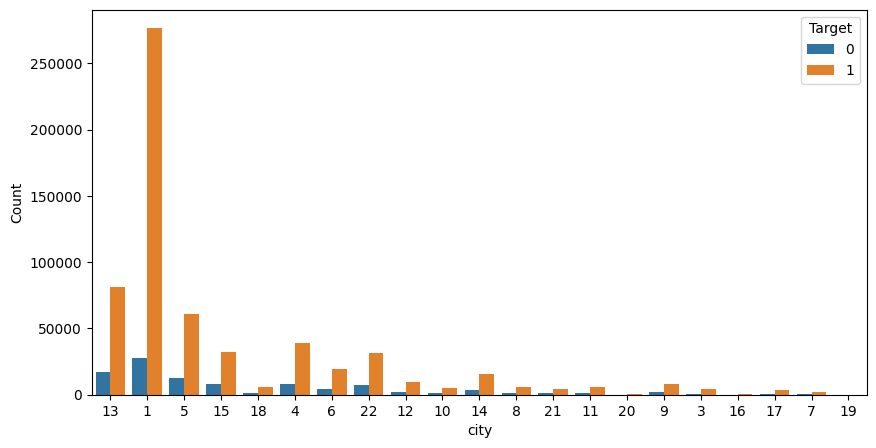

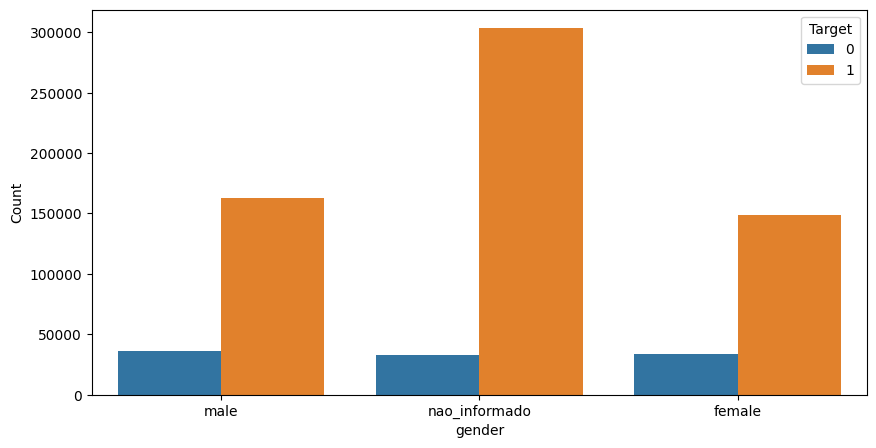

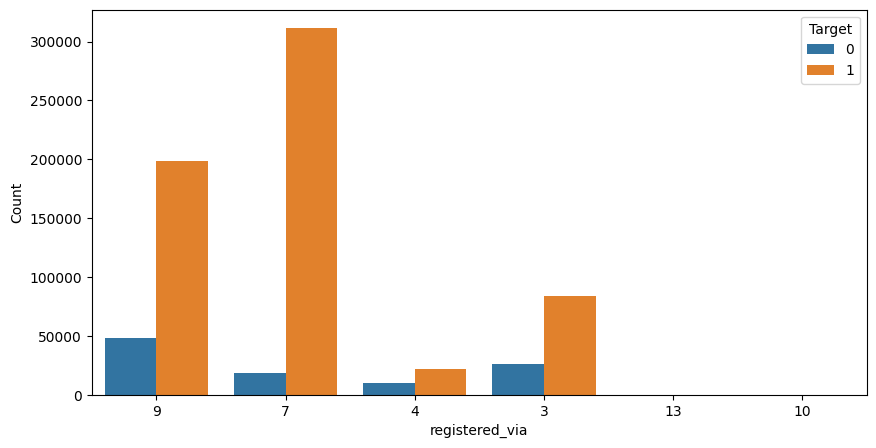

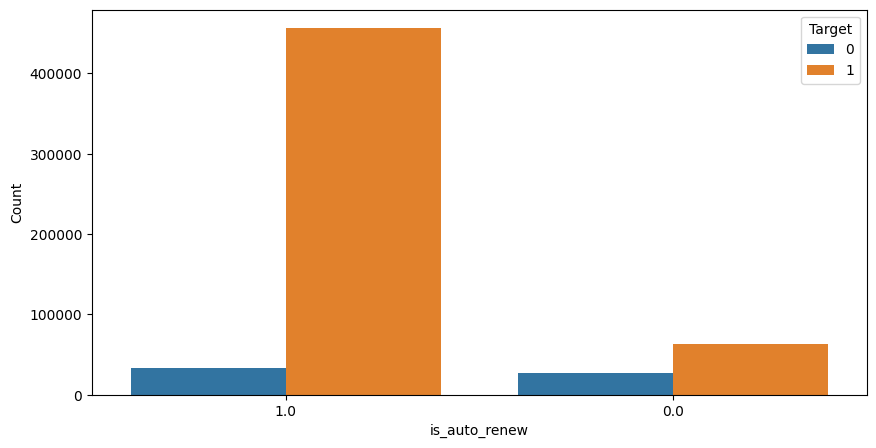

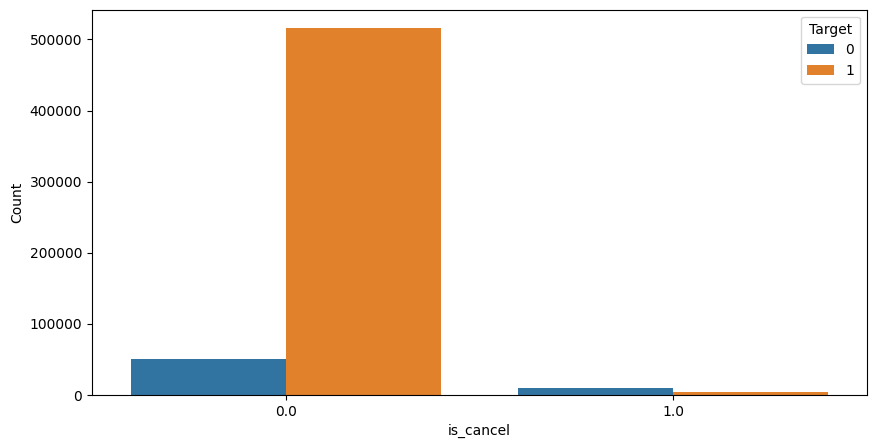

In [26]:
for i in cat_cols:
  master_pd[i] = master_pd[i].astype('string')
  plt.figure(figsize=(10, 5))
  sns.countplot(data=master_pd, x=i, hue='target')
  plt.xlabel(i)
  plt.ylabel('Count')
  plt.legend(title='Target', loc='upper right')
  plt.show()

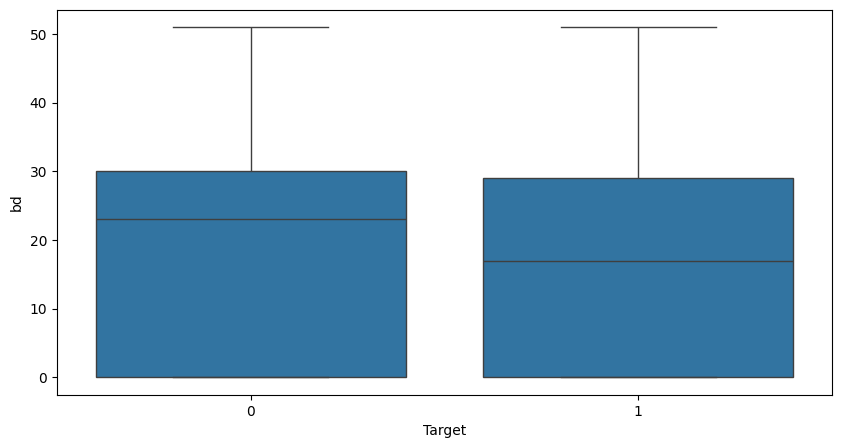

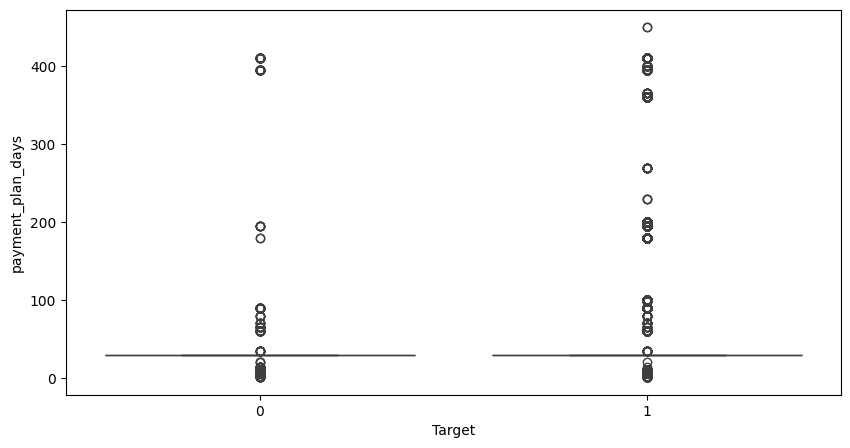

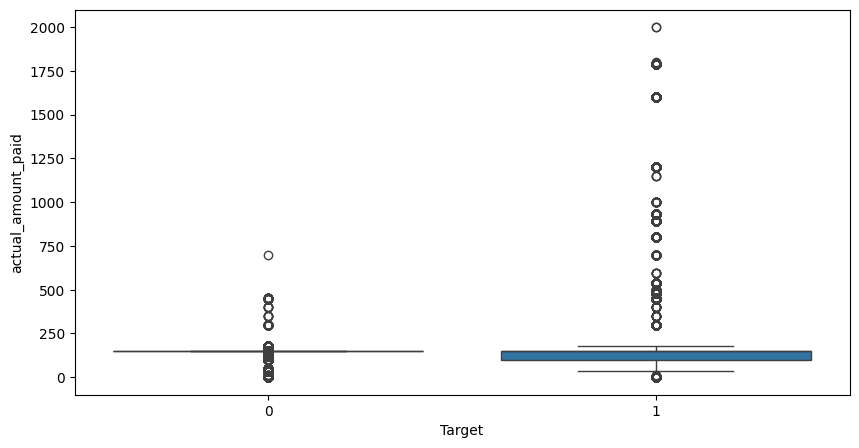

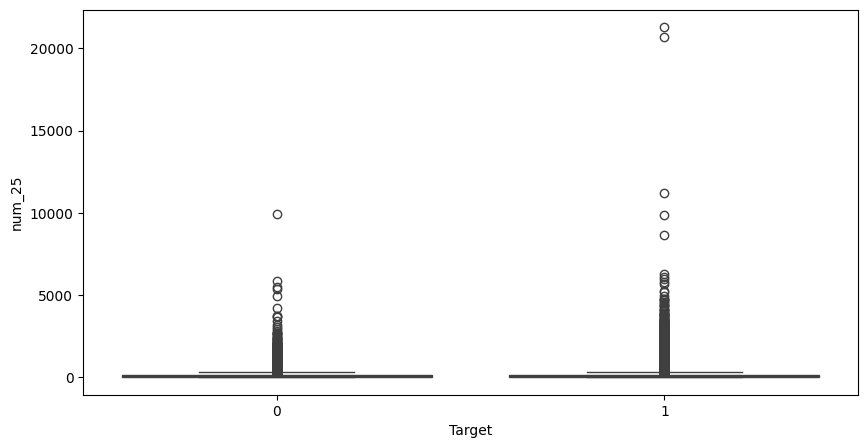

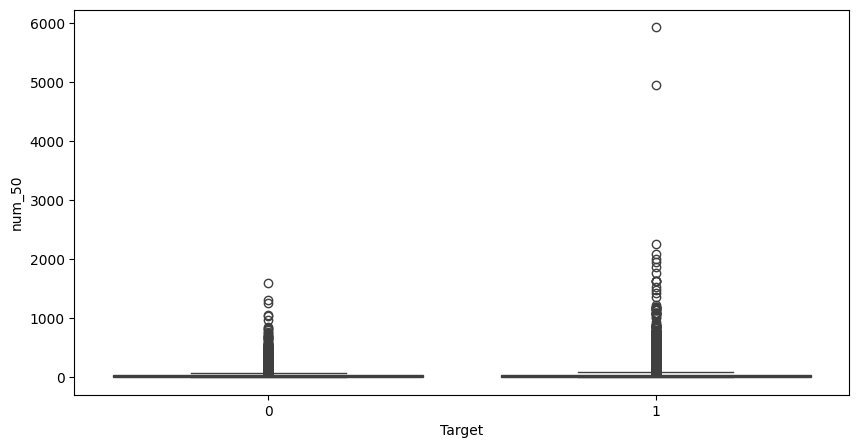

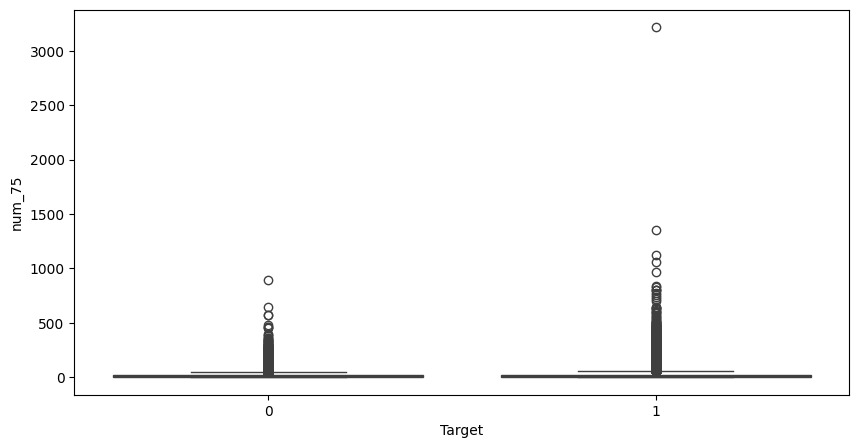

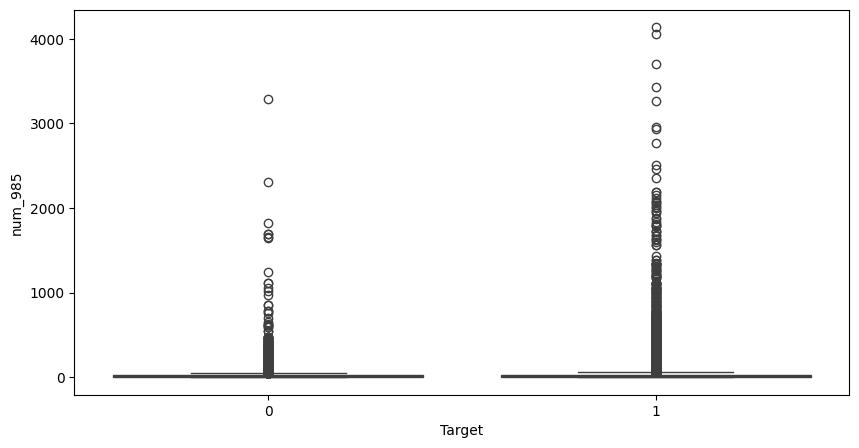

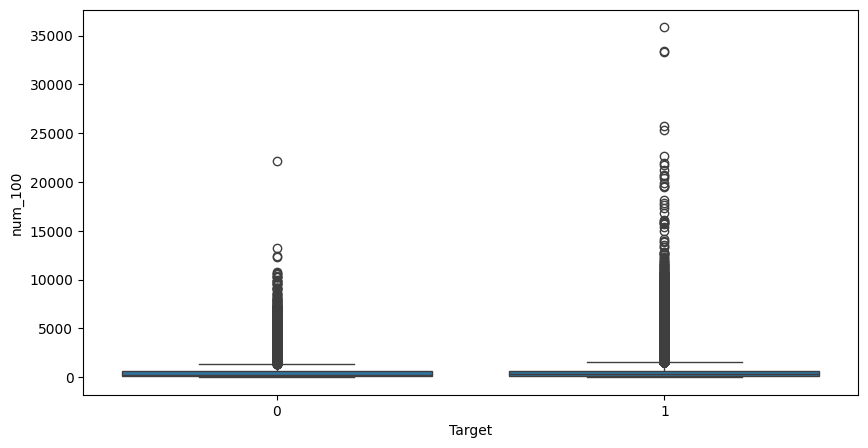

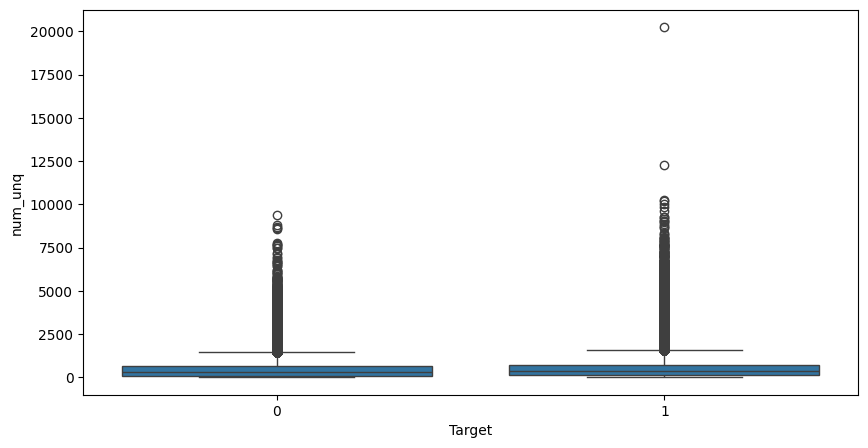

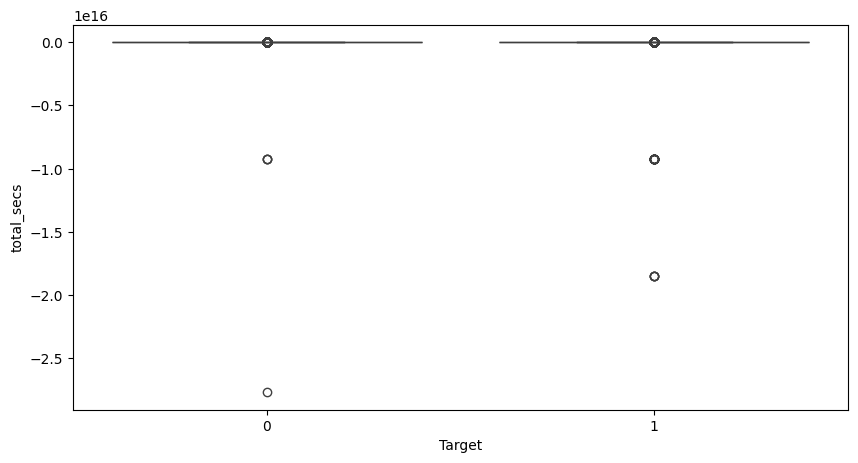

In [27]:
for i in num_cols:
  plt.figure(figsize=(10, 5))
  sns.boxplot(data=master_pd, x='target', y=i)
  plt.xlabel('Target')
  plt.ylabel(i)
  plt.show()

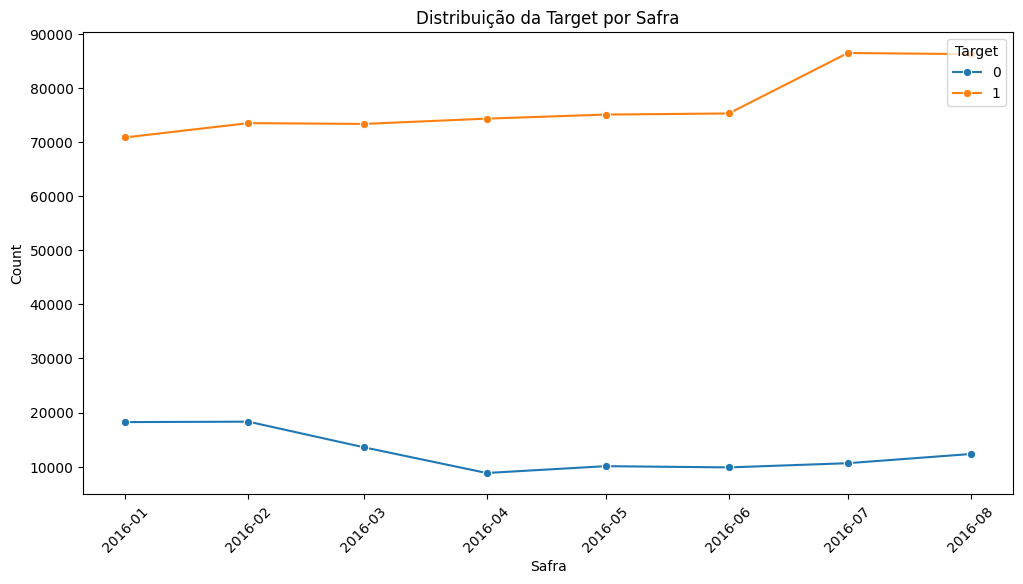

In [30]:
# Analise temporal da variável target
plt.figure(figsize=(12, 6))
sns.lineplot(data=master_pd.groupby(['safra', 'target']).size().reset_index(name='count'),
             x='safra', y='count', hue='target', marker='o')
plt.xlabel('Safra')
plt.ylabel('Count')
plt.title('Distribuição da Target por Safra')
plt.xticks(rotation=45)
plt.legend(title='Target', loc='upper right')
plt.show()

# Modelo
* Avaliação de dois algoritmos para realizar a classificação binária: XGBoost e regressão logística
*

In [ ]:
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder

# Separação dos dados de treino, teste e oot
X_oot = master_pd[master_pd['safra'] == '2016-09-01'].drop(columns=['msno', 'safra', 'target']) 
y_oot = master_pd[master_pd['safra'] == '2016-09-01']['target']

X = master_pd[master_pd['safra'] != '2016-09-01'].drop(columns=['msno', 'safra', 'target']) 
y = master_pd[master_pd['safra'] != '2016-09-01']['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_valid, test_size=0.5, random_state=42, stratify=y)

# Pré-processamento dos dados
cat_features = ['city', 'gender', 'registered_via', 'is_auto_renew', 'is_cancel']
encoder = TargetEncoder(cols=cat_features)
X_train[cat_features] = encoder.fit_transform(X_train[cat_features], y_train)
X_test[cat_features] = encoder.transform(X_test[cat_features])

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, log_loss
)

def get_binary_classification_metrics(y_true, y_pred, y_pred_proba=None):
    """
    Retorna um DataFrame pandas com as principais métricas de avaliação para classificação binária.

    Parâmetros:
    - y_true: array-like, rótulos verdadeiros
    - y_pred: array-like, predições do modelo (0 ou 1)
    - y_pred_proba: array-like, probabilidades da classe positiva (opcional, recomendado)

    Retorno:
    - metrics_df: pandas.DataFrame com as métricas
    """

    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0)
    }
    metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
    metrics['pr_auc'] = average_precision_score(y_true, y_pred_proba)
    metrics['log_loss'] = log_loss(y_true, y_pred_proba)

    # Matriz de confusão (TP, FP, TN, FN)
    cm = confusion_matrix(y_true, y_pred)
    metrics['tn'] = cm[0, 0]
    metrics['fp'] = cm[0, 1]
    metrics['fn'] = cm[1, 0]
    metrics['tp'] = cm[1, 1]

    # Retorna em DataFrame para fácil visualização
    metrics_df = pd.DataFrame([metrics])
    return metrics_df


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Espaço de busca de hiperparâmetros
space = {
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', range(50, 300)),
    'gamma': hp.uniform('gamma', 0, 5),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

def objective(params):
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        **params
    )
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:, 1]
    f1_score = f1_score(y_test, preds)
    return {'loss': -f1_score, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=30, 
            trials=trials, 
            rstate=np.random.RandomState(42))

print("Melhores hiperparâmetros encontrados:", best)

# Treinando o modelo final com os melhores hiperparâmetros
best_params = {
    'max_depth': range(3, 10)[best['max_depth']],
    'learning_rate': best['learning_rate'],
    'n_estimators': range(50, 300)[best['n_estimators']],
    'gamma': best['gamma'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda']
}

final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    **best_params
)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)